# Was importiert Deutschland aus den USA?

Stand: 2. Mai 2025

## Daten

| Title                                                     | File                            | Source                                                                                                            |
| --------------------------------------------------------- | ------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| Außenhandelsstatistik, 2-Steller                          | `/data/51000-0007_de_flat.csv`  | [Destatis, Tabelle 51000-0007](https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007) |
| Außenhandelsstatistik, 4/6-Steller                        | `/data/impex-6d/*`              | [Destatis, Tabelle 51000-0009](https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007) |
| Außenhandelsstatistik, 8-Steller (nur Soja-Produkte)      | `/data/51000-0013_de_flat.csv`  | [Destatis, Tabelle 51000-0013](https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007) |
| Warenverzeichnis für die Außenhandelsstatistik, 4-Steller | `/data/genesis-products-4d.csv` | [Genesis-API](https://www-genesis.destatis.de/genesisWS/rest/2020/catalogue/values2variable)                      |
| Warenverzeichnis für die Außenhandelsstatistik, 6-Steller | `/data/genesis-products-6d.csv` | [Genesis-API](https://www-genesis.destatis.de/genesisWS/rest/2020/catalogue/values2variable)                      |
| Länderverzeichnis für die Außenhandelsstatistik           | `/data/genesis-countries.csv`   | [Genesis-API](https://www-genesis.destatis.de/genesisWS/rest/2020/catalogue/values2variable)                      |
| Lebensmittel 2-Steller                                    | n/a                             | Eigene Recherche                                                                                                  |
| Soja-Lebensmittel 8-Steller                               | n/a                             | Eigene Recherche                                                                                                  |

### Notitzen

- [Combined Nomenclature](https://taxation-customs.ec.europa.eu/customs-4/calculation-customs-duties/customs-tariff/combined-nomenclature_de)
- [Genesis API docs](https://www-genesis.destatis.de/datenbank/online/docs/GENESIS-Webservices_Einfuehrung.pdf)

## 1. Data wrangling

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import json
from io import StringIO
from tqdm import tqdm
tqdm.pandas()

from dotenv import dotenv_values
secrets = dotenv_values(".env") 

import sys
sys.path.append('..')

from utils.get_destatis_variable_values import get_destatis_variable_values
from utils.get_destatis_table import get_destatis_table
from utils.try_cache import try_cache
from utils.plot_nested_treemap import plot_nested_treemap
from utils.plot_nested_treemap import sort_tree

pd.set_option('display.max_colwidth', None)

In [4]:
raw = {}
data = {}

In [5]:
raw["impex2d"] = pd.read_csv("./data/51000-0007_de_flat.csv",
                               	delimiter=";",
                               	decimal=",",
                               	thousands=".",
                               	parse_dates=["time"],
                               	converters={"value": lambda x: pd.to_numeric(x.replace(",", "."), errors="coerce")})

raw["impex8d"] =  pd.read_csv("./data/51000-0013_de_flat.csv",
								delimiter=";",
								decimal=",",
								thousands=".",
								parse_dates=["time"],
								converters={"value": lambda x: pd.to_numeric(x, errors="coerce")})

In [6]:
raw["country_codes"] = try_cache("./data/genesis-countries.json", lambda: get_destatis_variable_values(var="STLAH", token=secrets["DESTATIS_TOKEN"]))
data["country_codes"] = pd.DataFrame(data=json.loads(raw["country_codes"])["List"])

raw["product_codes_4d"] = try_cache("./data/genesis-products-4d.json", lambda: get_destatis_variable_values(var="WAM4", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_4d"] = pd.DataFrame(data=json.loads(raw["product_codes_4d"])["List"])

raw["product_codes_6d"] = try_cache("./data/genesis-products-6d.json", lambda: get_destatis_variable_values(var="WAM6", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_6d"] = pd.DataFrame(data=json.loads(raw["product_codes_6d"])["List"])

In [7]:
# Own research
data["food_codes_2d"] = ["WA01", "WA02", "WA03", "WA04", "WA07", "WA08", "WA09", "WA10", "WA11", "WA15", "WA16", "WA17", "WA18", "WA19", "WA20", "WA21", "WA22",]
data["food_codes_4d"] = data["product_codes_4d"].loc[data["product_codes_4d"]["Code"].str[:4].isin(data["food_codes_2d"])]["Code"]
data["food_codes_6d"] = data["product_codes_6d"].loc[data["product_codes_6d"]["Code"].str[:4].isin(data["food_codes_2d"])]["Code"]
data["food_codes_6d"].values

array(['WA010110', 'WA010121', 'WA010129', ..., 'WA229799', 'WA229899',
       'WA229999'], dtype=object)

In [8]:
def parse_genesis_csv(csv):
	return pd.read_csv(StringIO(csv),
            	header=5,
            	skiprows=[6],
            	skipfooter=3,
            	delimiter=";",
            	decimal=",",
            	thousands=".",
            	engine="python",
            	parse_dates=["Unnamed: 0"],
            	converters=destatis_converters
				).rename(columns={
    				"Unnamed: 0": "year",
    				"Unnamed: 1": "country",
    				"Unnamed: 2": "product_code",
    				"Unnamed: 3": "product_label",
				})
	
destatis_converters = {
	"Ausfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce")
}

def get_paged_destatis_table(codes: list[str], codes_per_request: int = 1, dry_run = False):
	chunks = [codes[i:i + codes_per_request] for i in range(0, len(codes), codes_per_request)]
	result = pd.DataFrame()
	print(f"Received {len(codes)} attribute codes, generated {len(chunks)} chunks")
	if (dry_run):
		return
	with tqdm(total=len(chunks), unit=" chunk") as bar:
		for i, chunk in enumerate(chunks):
			bar.set_description(f"[{','.join(chunk)}]")
			t = try_cache(f"./data/impex-6d/{'_'.join(chunk)}.csv",
				lambda: get_destatis_table(
					token=secrets["DESTATIS_TOKEN"],
					password=secrets["DESTATIS_PASSWORD"],
					tables=["51000-0009"],
					start_year=2024,
					attributes={"STLAH": "*", "WAM6": ",".join(chunk)},
					silent=True,
					skip_credential_validation=(i > 0)), silent=True
			)
			d = parse_genesis_csv(t)
			result = pd.concat([result, d])
			bar.update(1)
	return result

data["impex4d"] = get_paged_destatis_table(data["food_codes_6d"].values, codes_per_request=5, dry_run=False)


Received 1001 attribute codes, generated 201 chunks


[WA229999]: 100%|██████████| 201/201 [00:11<00:00, 17.31 chunk/s]                                       


In [9]:
data["impex2d"] =  raw["impex2d"][["statistics_code", "time","1_variable_attribute_label", "2_variable_attribute_label", "3_variable_attribute_code", "3_variable_attribute_label", "value", "value_unit", "value_variable_label", "value_q"]].rename(columns={
        "1_variable_attribute_label": "destination",
        "2_variable_attribute_label": "origin",
        "3_variable_attribute_code": "product_code",
        "3_variable_attribute_label": "product_label",
	})

data["impex4d"]["product_group_2d"] = data["impex4d"]["product_code"].str[:4]

data["impex8d"] =  raw["impex8d"][
    ["time", "value_variable_label", "value", "value_unit","1_variable_attribute_label", "2_variable_attribute_code","2_variable_attribute_label", "statistics_code","value_q"]
    ].rename(columns={
        "2_variable_attribute_code": "product_code",
        "2_variable_attribute_label": "product_label",
	})

## 2. Analyse

- > Welche Sojaprodukte importieren wir aus den USA? In welcher Menge? ([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744121796955?context=%7B%22contextType%22%3A%22chat%22%7D))
- > Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.
([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D))

### 2.1 Welche Soja-Produkte importieren wir aus den USA?

Insgesamt wurden im Jahr 2024 Sojaprodukte im Wert von **€3.189.942.000** aus den USA importiert.

In [10]:
# Own research
soy_codes = [
    "WA12019000",
    "WA12081000",
    "WA15071090",
    "WA15079090",
    "WA21031000",
    "WA22029911",
    "WA22029915"
]

d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["product_label"].str.contains("Soja"))
].sort_values("value", ascending=False).reset_index(drop=True)[["time", "product_label", "product_code", "value", "value_unit"]]

d

,time,product_label,product_code,value,value_unit
0,2024-01-01,"Sojabohnen, auch geschrotet, a.n.g.",WA12019000,1630299.0,Tsd. EUR
1,2024-01-01,Ölkuchen u.a. feste Rückstände von Sojaöl,WA23040000,1120665.0,Tsd. EUR
2,2024-01-01,"Getränke aus Soja, Nüssen, Samen, a.n.g. l",WA22029915,190950.0,Tsd. EUR
3,2024-01-01,"Rohes Sojaöl, zur Verwendung als Lebensmittel",WA15071090,56707.0,Tsd. EUR
4,2024-01-01,"Sojasoße, zubereitet",WA21031000,50471.0,Tsd. EUR
5,2024-01-01,"Sojaöl, raffiniert, zu Lebensmittelzwecken",WA15079090,48251.0,Tsd. EUR
6,2024-01-01,"Rohes Sojaöl, zu industriellen Zwecken",WA15071010,38385.0,Tsd. EUR
7,2024-01-01,"Getränke aus Soja, Eiweißgehalt >= 2,8 GHT l",WA22029911,36122.0,Tsd. EUR
8,2024-01-01,Mehl von Sojabohnen,WA12081000,9238.0,Tsd. EUR
9,2024-01-01,Sojabohnen zur Aussaat,WA12011000,5822.0,Tsd. EUR


In [11]:
d["value"].sum() * 1000

3189942000.0

### 2.2 Welche 10 Lebensmittel werden am meisten aus den USA importiert?

In der Außenhandelsstatistik werden Produkte in Gruppen mit 2, 4, 6, und 8 Ziffern aufgeteilt. Die Ergebnisse varrieren je nachdem welche Gruppierung man betrachtet. Unter **2-stelligen Warengruppen** waren die größten Lebensmittelimporte im Jahr 2024, gemessen nach Wert in Euro:

1. Genießbare Früchte und Nüsse (`WA08`)
2. Getränke, alkoholhaltige Flüssigkeiten, Essig (`WA22`)
3. Fische, Krebs- und Weichtiere (`WA03`)

Unter **6-stelligen Warengruppen** waren die zehn größten Lebensmittelimporte im gleichen Zeitraum:

1. Pistazien mit Schale (`WA080251`)
2. Mandeln ohne Schale (`WA080212`)
3. Whisky (`WA220830`)

In [12]:
top = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"].isin(["Einfuhr: Wert"]))
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(data["food_codes_2d"]))
].nlargest(10, ["value"])

top_imports_2d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"].isin(["Einfuhr: Wert", "Einfuhr: Gewicht"]))
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(top["product_code"]))
]
pd.pivot_table(top_imports_2d[["time", "origin", "product_code", "product_label", "value_variable_label", "value", "value_unit"]], index=["time", "origin", "product_code", "product_label"], values="value", columns="value_variable_label").sort_values("Einfuhr: Wert", ascending=False)

value_variable_label                                                                                  Einfuhr: Gewicht  \
time       origin                         product_code product_label                                                     
2024-01-01 Vereinigte Staaten von Amerika WA08         Genießbare Früchte und Nüsse                           182366.0   
                                          WA22         Getränke, alkoholhaltige Flüssigkeiten, Essig           56161.3   
                                          WA03         Fische, Krebs- und Weichtiere                           49884.2   
                                          WA21         Verschiedene Lebensmittelzubereitungen                  11996.2   
                                          WA20         Zubereitungen von Gemüse, Früchten usw.                 13885.5   
                                          WA07         Gemüse, Pflanzen für Ernährung                          23808.1   
                                          WA02         Fleisch                                                  1318.7   
                                          WA15         Tierische und pflanzliche Fette, Öle, Wachs              4233.2   
                                          WA18         Kakao und Zubereitungen aus Kakao                        1543.6   
                                          WA01         Lebende Tiere                                              85.5   

value_variable_label                                                                                  Einfuhr: Wert  
time       origin                         product_code product_label                                                 
2024-01-01 Vereinigte Staaten von Amerika WA08         Genießbare Früchte und Nüsse                        912342.0  
                                          WA22         Getränke, alkoholhaltige Flüssigkeiten, Essig       255691.0  
                                          WA03         Fische, Krebs- und Weichtiere                       187111.0  
                                          WA21         Verschiedene Lebensmittelzubereitungen              133619.0  
                                          WA20         Zubereitungen von Gemüse, Früchten usw.              61437.0  
                                          WA07         Gemüse, Pflanzen für Ernährung                       42963.0  
                                          WA02         Fleisch                                              31596.0  
                                          WA15         Tierische und pflanzliche Fette, Öle, Wachs          27894.0  
                                          WA18         Kakao und Zubereitungen aus Kakao                    22296.0  
                                          WA01         Lebende Tiere                                        20362.0

In [13]:
top_imports_6d = data["impex4d"].loc[
    data["impex4d"]["country"] == "Vereinigte Staaten von Amerika"
	].nlargest(10, ["Einfuhr: Wert"])

pd.pivot_table(top_imports_6d,
               index=["year", "country", "product_group_2d", "product_code", "product_label"],
               values=["Einfuhr: Gewicht", "Einfuhr: Wert"]).sort_values("Einfuhr: Wert", ascending=False)

Einfuhr: Gewicht  \
year       country                        product_group_2d product_code product_label                                                       
2024-01-01 Vereinigte Staaten von Amerika WA08             WA080251     Pistazien in der Schale, frisch oder getrocknet           48012.0   
                                                           WA080212     Mandeln, frisch oder getrocknet, ohne Schale              54447.2   
                                          WA22             WA220830     Whisky                                                    25158.1   
                                          WA03             WA030475     Filets vom Pazifischen Pollack, gefroren                  40480.1   
                                          WA08             WA080232     Walnüsse ohne Schale, frisch oder getrocknet              30701.3   
                                          WA21             WA210690     Lebensmittelzubereitungen, a.n.g.                          4387.1   
                                          WA08             WA080252     Pistazien ohne Schale, frisch oder getrocknet              5943.5   
                                          WA22             WA220421     Wein aus frischen Weintrauben, <=2l                        5709.9   
                                          WA20             WA200893     Preiselbeeren und Moosbeeren, zubereitet                   8183.6   
                                          WA08             WA080610     Weintrauben, frisch                                        8922.3   

                                                                                                                         Einfuhr: Wert  
year       country                        product_group_2d product_code product_label                                                   
2024-01-01 Vereinigte Staaten von Amerika WA08             WA080251     Pistazien in der Schale, frisch oder getrocknet       313278.0  
                                                           WA080212     Mandeln, frisch oder getrocknet, ohne Schale          234028.0  
                                          WA22             WA220830     Whisky                                                164607.0  
                                          WA03             WA030475     Filets vom Pazifischen Pollack, gefroren              132401.0  
                                          WA08             WA080232     Walnüsse ohne Schale, frisch oder getrocknet          131712.0  
                                          WA21             WA210690     Lebensmittelzubereitungen, a.n.g.                      86963.0  
                                          WA08             WA080252     Pistazien ohne Schale, frisch oder getrocknet          75089.0  
                                          WA22             WA220421     Wein aus frischen Weintrauben, <=2l                    35735.0  
                                          WA20             WA200893     Preiselbeeren und Moosbeeren, zubereitet               30061.0  
                                          WA08             WA080610     Weintrauben, frisch                                    27353.0

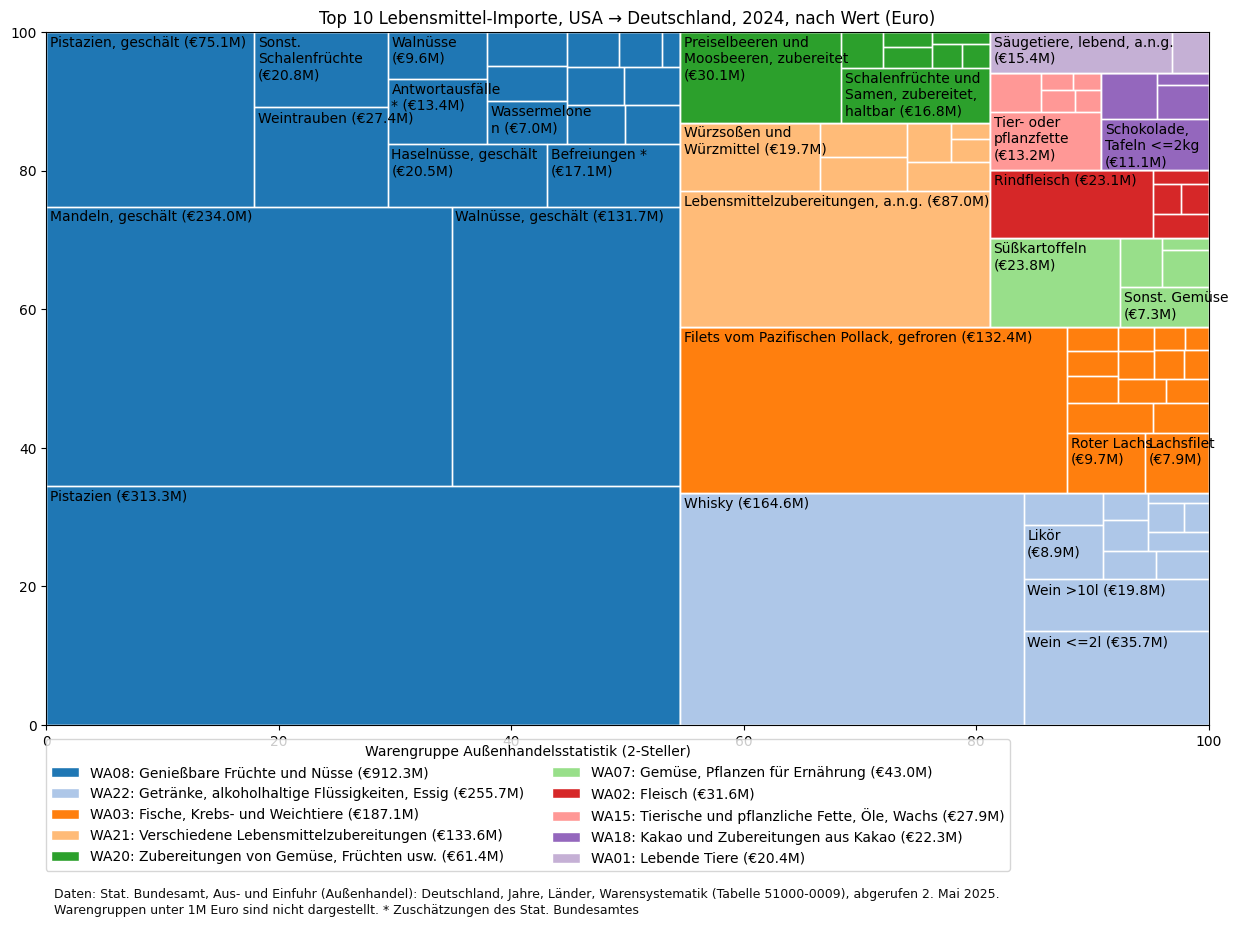

In [20]:
# Prepare labels
long_label = d["product_code"] + ": " + d["product_label"] + d["value"].map(lambda x: f" (€{round(x/1000, 1):,}M)")
with open("./display_labels.json") as f:
	display_labels = json.load(f)

# Build nested tree data
tree = []
top_imports_2d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"].isin(["Einfuhr: Wert"]))
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(top["product_code"]))
]
d = top_imports_2d.sort_values("value", ascending=False).reset_index()[:10][["product_code", "product_label", "value"]]
for di in d.to_dict("records"):
	sg = data["impex4d"].loc[
    	(data["impex4d"]["country"] == "Vereinigte Staaten von Amerika")
		& (data["impex4d"]["product_group_2d"] == di["product_code"])
		& ~(data["impex4d"]["Einfuhr: Wert"].isna())
		& ~(data["impex4d"]["Einfuhr: Wert"] < 1000)
	].rename(columns={"Einfuhr: Wert": "value"})
	sg["label"] = sg["product_label"].apply(lambda x: display_labels[x] if x in display_labels else x) + "\n" + sg["value"].apply(lambda x: f"(€{round(x/1000, 1):,}M)")
	if len(sg) > 0:
		tree.append(sg[["value", "product_code", "product_label", "label"]].to_dict("records"))


# Plot
fig, ax = plt.subplots(figsize=(15,9))
plt.title("Top 10 Lebensmittel-Importe, USA → Deutschland, 2024, nach Wert (Euro)")
plot_nested_treemap(sort_tree([tree], "value"),fig=fig, ax=ax, key="value", label="label", cmap="tab20")
leg = fig.legend(long_label, loc="lower left", ncols=2, bbox_to_anchor=(.12, -0.06, .8, 1), title="Warengruppe Außenhandelsstatistik (2-Steller)")
ax.text(x=.13, y=-.1, s="Daten: Stat. Bundesamt, Aus- und Einfuhr (Außenhandel): Deutschland, Jahre, Länder, Warensystematik (Tabelle 51000-0009), abgerufen 2. Mai 2025.\nWarengruppen unter 1M Euro sind nicht dargestellt. * Zuschätzungen des Stat. Bundesamtes", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()

### 2.3 Wie groß ist der Anteil von US-Importen an diesen Warengruppen?

Der Anteil der US-Importe am gesamten Import variiert stark nach Warengruppe. Bei **Pistazien mit Schale (frisch oder getrocknet)** beträgt er rund 95%, bei **Mandeln, frisch oder getrocknet, ohne Schale** 52%, bei **Weintrauben** dagegen nur 2%. Siehe unten für die vollständige Tabelle.

In [21]:
def compute_total_import_value(x, field):
	d = data["impex4d"].loc[
		(data["impex4d"]["product_code"] == x)
	]
	return d[field].sum()

result = pd.DataFrame()
top_imports_2d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"].isin(["Einfuhr: Wert"]))
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(top["product_code"]))
].nlargest(10, "value")

for g2d in top_imports_2d["product_code"].values:
    res = data["impex4d"].loc[
        (data["impex4d"]["product_code"].str[:4] == g2d)
		& (data["impex4d"]["country"] == "Vereinigte Staaten von Amerika")
        & ~(data["impex4d"]["product_label"].str.contains("Zuschätzungen"))
	].nlargest(10, "Einfuhr: Wert")
    result = pd.concat([result, res])

result["total_import_value"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Wert"))
result["total_import_weight"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Gewicht"))

In [24]:
result["product_2d"] = result["product_code"].str[:4]
result["us_share_value"] = result["Einfuhr: Wert"].div(result["total_import_value"]).round(4)
result["us_share_weight"] = result["Einfuhr: Gewicht"].div(result["total_import_weight"]).round(4)

result_formatted = result[["product_label","product_code", "total_import_value", "total_import_weight", "Einfuhr: Wert", "Einfuhr: Gewicht", "us_share_weight", "us_share_value"]].rename(columns={
    "product_code": "product_6d",
    "Einfuhr: Wert": "us_import_value",
    "Einfuhr: Gewicht": "us_import_weight",
}).reset_index(drop=True)
pd.set_option('display.max_rows', 500)
result_formatted.to_csv("./output/imports.csv", index=False)
result_formatted

,product_label,product_6d,total_import_value,total_import_weight,us_import_value,us_import_weight,us_share_weight,us_share_value
0,"Pistazien in der Schale, frisch oder getrocknet",WA080251,331379.0,50350.5,313278.0,48012.0,0.9536,0.9454
1,"Mandeln, frisch oder getrocknet, ohne Schale",WA080212,449843.0,95575.3,234028.0,54447.2,0.5697,0.5202
2,"Walnüsse ohne Schale, frisch oder getrocknet",WA080232,215143.0,47107.4,131712.0,30701.3,0.6517,0.6122
3,"Pistazien ohne Schale, frisch oder getrocknet",WA080252,185052.0,13073.6,75089.0,5943.5,0.4546,0.4058
4,"Weintrauben, frisch",WA080610,992218.0,353134.8,27353.0,8922.3,0.0253,0.0276
5,"Schalenfrüchte, a.n.g., frisch oder getrocknet",WA080299,55562.0,6558.5,20805.0,2255.0,0.3438,0.3744
6,"Haselnüsse ohne Schale, frisch oder getrocknet",WA080222,539748.0,69477.6,20538.0,3318.6,0.0478,0.0381
7,"Walnüsse in der Schale, frisch oder getrocknet",WA080231,25933.0,11116.7,9589.0,5324.2,0.4789,0.3698
8,"Wassermelonen, frisch",WA080711,357164.0,479884.6,7014.0,6165.3,0.0128,0.0196
9,"Pflaumen, getrocknet",WA081320,30162.0,7289.4,5837.0,1042.0,0.1429,0.1935
